## Bibliotecas e dataset

In [1]:
!pip install -q git+https://github.com/tensorflow/docs#

In [2]:
import librosa

import numpy as np
import pandas as pd
import os

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers 

import matplotlib.pyplot as plt
from IPython import display
from IPython.display import clear_output

import glob
import imageio
import time
import IPython.display as ipd

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
seed=123
tf.compat.v1.set_random_seed(seed)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

# Gerando músicas a partir do gênero

In [4]:
#train_size = 60000
BATCH_SIZE = 10
#test_size = 10000
epochs = 20
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 10

BASE_PATH = 'Data/genres_original'

optimizer = tf.keras.optimizers.Adam(0.0003,beta_1=0.9, beta_2=0.999,epsilon=1e-08)

# Funções

In [5]:
## Carrega a lista de arquivos
def DatasetLoader(class_):
    music_list = np.array(sorted(os.listdir(BASE_PATH+'/'+class_)))
    train_music_1 = list(music_list[[0,52,19,39,71,12,75,85,3,45,24,46,88]]) #99,10,66,76,41
    train_music_2 = list(music_list[[4,43,56,55,45,31,11,13,70,37,21,78]]) #65,32,53,22,19,80,89, 
    TrackSet_1 = [(BASE_PATH)+'/'+class_+'/%s'%(x) for x in train_music_1]
    TrackSet_2 = [(BASE_PATH)+'/'+class_+'/%s'%(x) for x in train_music_2]

    return TrackSet_1, TrackSet_2

## Carrega os audios
def load(file_):
    data_, sampling_rate = librosa.load(file_,sr=3000, offset=0.0, duration=30)
    #print(data_.shape)
    data_ = data_.reshape(1,90001)
    return data_

#map_data = lambda filename: tf.compat.v1.py_func(load, [filename], [tf.float32])

import librosa.display

## Cria e salva os waveplots
def generate_and_save_images(model, epoch, test_sample, save):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    fig = plt.figure(figsize=(18, 15))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        wave = np.asarray(predictions[i])
        #librosa.display.waveplot(wave[0], sr=3000)

    # tight_layout minimizes the overlap between 2 sub-plots
    plt.savefig('{}_{:04d}.png'.format(save, epoch))
    plt.savefig('{}_{:04d}.png'.format(save, epoch))
    plt.show()
    

## Treinamento
def train(train_dataset, test_dataset, model, save):
    for epoch in range(1, epochs + 1):
        start_time = time.time()
        for train_x in train_dataset:
            train_x = np.asarray(train_x)[0]
            train_step(model, train_x, optimizer)
        end_time = time.time()

        loss = tf.keras.metrics.Mean()
        for test_x in test_dataset:
            test_x = np.asarray(test_x)[0]
            loss(compute_loss(model, test_x))
        display.clear_output(wait=False)
        elbo = -loss.result()
        print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'.format(epoch, 
                                                                                       elbo, 
                                                                                       end_time - start_time
                                                                                      ))
        generate_and_save_images(model,
                                 epoch, 
                                 test_sample,
                                 save)

## Predição a partir da média e variância
def inference(test_dataset, model):  
    save_music = []
    for test in test_dataset:
        mean, logvar = model.encode(test)
        z = model.reparameterize(mean, logvar)
        predictions = model.sample(z)
        for pred in predictions:
            wave = np.asarray(pred)
            save_music.append(wave)
    return save_music

# Arquitetura da rede

In [6]:
## Resnet
class Resnet1DBlock(tf.keras.Model):
    def __init__(self, kernel_size, filters,type='encode'):
        super(Resnet1DBlock, self).__init__()
    
        if type=='encode':
            self.conv1a = layers.Conv1D(filters, kernel_size, 2,padding="same")
            self.conv1b = layers.Conv1D(filters, kernel_size, 1,padding="same")
            self.norm1a = tfa.layers.InstanceNormalization()
            self.norm1b = tfa.layers.InstanceNormalization()
        if type=='decode':
            self.conv1a = layers.Conv1DTranspose(filters, kernel_size, 1,padding="same")
            self.conv1b = layers.Conv1DTranspose(filters, kernel_size, 1,padding="same")
            self.norm1a = tf.keras.layers.BatchNormalization()
            self.norm1b = tf.keras.layers.BatchNormalization()
        else:
            return None

    def call(self, input_tensor):
        x = tf.nn.relu(input_tensor)
        x = self.conv1a(x)
        x = self.norm1a(x)
        x = layers.LeakyReLU(0.4)(x)

        x = self.conv1b(x)
        x = self.norm1b(x)
        x = layers.LeakyReLU(0.4)(x)

        x += input_tensor
        return tf.nn.relu(x)

## Convolutional Variational AutoEncoder
class CVAE(tf.keras.Model):
    """Convolutional variational autoencoder."""

    def __init__(self, latent_dim, shape=90001):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(1,shape)),
                layers.Conv1D(64,1,2),
                Resnet1DBlock(64,1),
                layers.Conv1D(128,1,2),
                Resnet1DBlock(128,1),
                layers.Conv1D(128,1,2),
                Resnet1DBlock(128,1),
                layers.Conv1D(256,1,2),
                Resnet1DBlock(256,1),
                # No activation
                layers.Flatten(),
                layers.Dense(latent_dim+latent_dim)

            ]
        )
        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                layers.Reshape(target_shape=(1,latent_dim)),
                Resnet1DBlock(512,1,'decode'),
                layers.Conv1DTranspose(512,1,1),
                Resnet1DBlock(256,1,'decode'),
                layers.Conv1DTranspose(256,1,1),
                Resnet1DBlock(128,1,'decode'),
                layers.Conv1DTranspose(128,1,1),
                Resnet1DBlock(64,1,'decode'),
                layers.Conv1DTranspose(64,1,1),
                # No activation
                layers.Conv1DTranspose(shape,1,1),
            ]
        )
    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(200, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)
    @tf.function
    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar
    @tf.function
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean
    @tf.function
    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

## Função de Densidade de Probabilidade da Dist. Normal
@tf.function
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
         -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
          axis=raxis)

## Calcula a função de perda (loss)
@tf.function
def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1,2])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

## Iteração do treinamento
#@tf.function
def train_step(model, x, optimizer):
    
    """Executes one training step and returns the loss.

       This function computes the loss and gradients, and uses the latter to
       update the model's parameters.
     """
    with tf.GradientTape() as tape:
            mean, logvar = model.encode(x)
            z = model.reparameterize(mean, logvar)
            x_logit = model.decode(z)
            cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
            logpx_z = -tf.reduce_sum(cross_ent, axis=[1,2])
            logpz = log_normal_pdf(z, 0., 0.)
            logqz_x = log_normal_pdf(z, mean, logvar)
            loss_KL = -tf.reduce_mean(logpx_z + logpz - logqz_x)
            reconstruction_loss = tf.reduce_mean(
                     tf.keras.losses.binary_crossentropy(x, x_logit)
                 )
            total_loss = reconstruction_loss+ loss_KL
    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

## Jazz

Epoch: 20, Test set ELBO: -24493.935546875, time elapse for current epoch: 1.9407169818878174


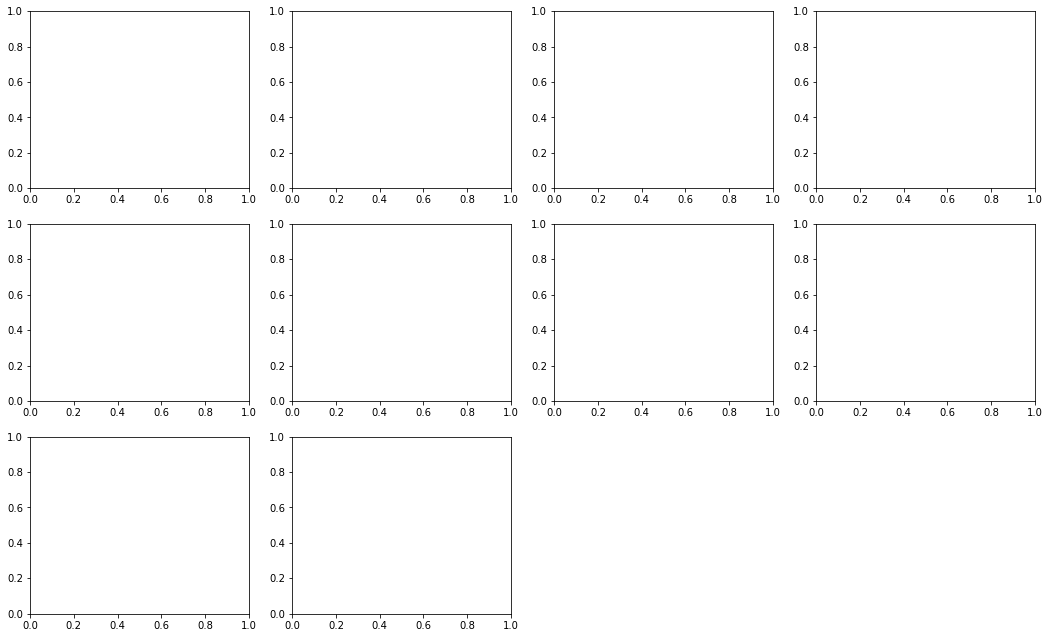

In [7]:
map_data = lambda filename: tf.compat.v1.py_func(load, [filename], [tf.float32])

TrackSet_1, TrackSet_2 = DatasetLoader('jazz')

train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((TrackSet_1))
    .map(map_data, num_parallel_calls=AUTOTUNE)
    .shuffle(3)
    .batch(BATCH_SIZE)
)
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices((TrackSet_2))
    .map(map_data, num_parallel_calls=AUTOTUNE)
    .shuffle(3)
    .batch(BATCH_SIZE)
)

random_vector_for_generation = tf.random.normal(shape=[num_examples_to_generate, latent_dim])
model_jazz = CVAE(latent_dim)

# Pick a sample of the test set for generating output images
assert BATCH_SIZE >= num_examples_to_generate
for test_batch in test_dataset.take(1):
    test_sample = test_batch[0]
    
train(train_dataset, test_dataset, model_jazz, 'jazz')

anim_file_1 = 'jazz_cvae.gif'

with imageio.get_writer(anim_file_1, mode='I') as writer:
    filenames = glob.glob('jazz*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)
    
saved_jazz = inference(test_dataset, model_jazz)


In [8]:
music1=saved_jazz[0][0]
ipd.Audio(music1,rate=3000)

In [9]:
music2=saved_jazz[9][0]
ipd.Audio(music2,rate=3000)

In [10]:
music3=saved_jazz[5][0]
ipd.Audio(music3,rate=3000)

## Classical

Epoch: 20, Test set ELBO: 79433.2890625, time elapse for current epoch: 2.042325258255005


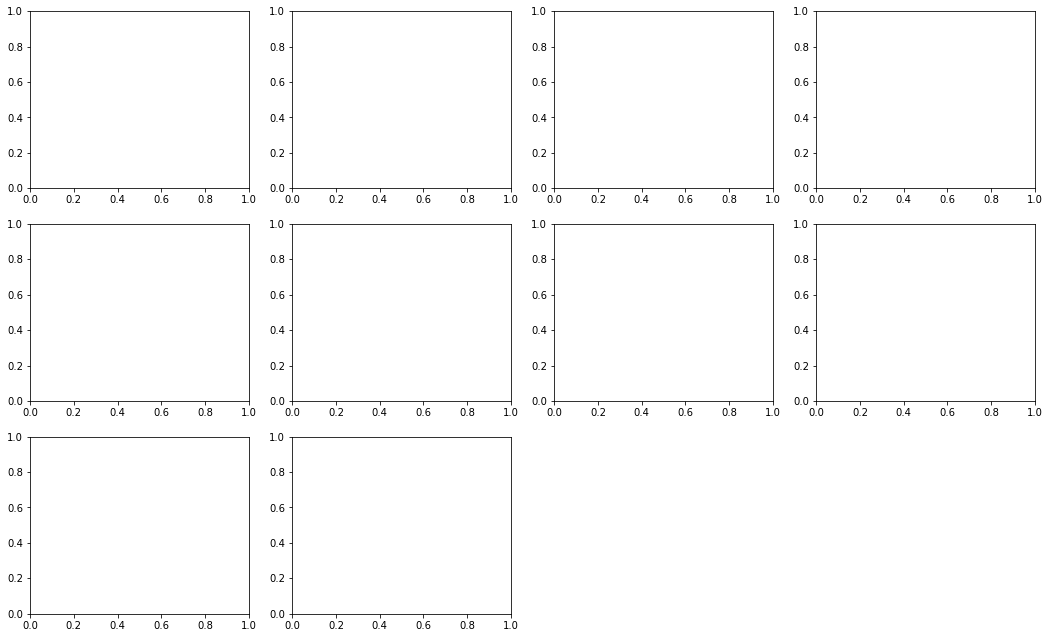

In [11]:
map_data = lambda filename: tf.compat.v1.py_func(load, [filename], [tf.float32])

TrackSet_1, TrackSet_2 = DatasetLoader('classical')

train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((TrackSet_1))
    .map(map_data, num_parallel_calls=AUTOTUNE)
    .shuffle(3)
    .batch(BATCH_SIZE)
)
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices((TrackSet_2))
    .map(map_data, num_parallel_calls=AUTOTUNE)
    .shuffle(3)
    .batch(BATCH_SIZE)
)

#optimizer = tf.keras.optimizers.Adam(0.0003,beta_1=0.9, beta_2=0.999,epsilon=1e-08)

random_vector_for_generation = tf.random.normal(shape=[num_examples_to_generate, latent_dim])
model_classical = CVAE(latent_dim)

# Pick a sample of the test set for generating output images
assert BATCH_SIZE >= num_examples_to_generate
for test_batch in test_dataset.take(1):
    test_sample = test_batch[0]

generate_and_save_images(model_classical, 0, test_sample, 'classical')
train(train_dataset, test_dataset, model_classical, 'classical')

anim_file_1 = 'classical_cvae.gif'

with imageio.get_writer(anim_file_1, mode='I') as writer:
    filenames = glob.glob('classical*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file_1)


saved_classical = inference(test_dataset, model_classical)


In [12]:
music1=saved_classical[0][0]
ipd.Audio(music1,rate=3000)

In [13]:
music2=saved_classical[9][0]
ipd.Audio(music2,rate=3000)

In [14]:
music3=saved_classical[5][0]
ipd.Audio(music3,rate=3000)

## Disco

Epoch: 20, Test set ELBO: 137504.078125, time elapse for current epoch: 2.1690657138824463


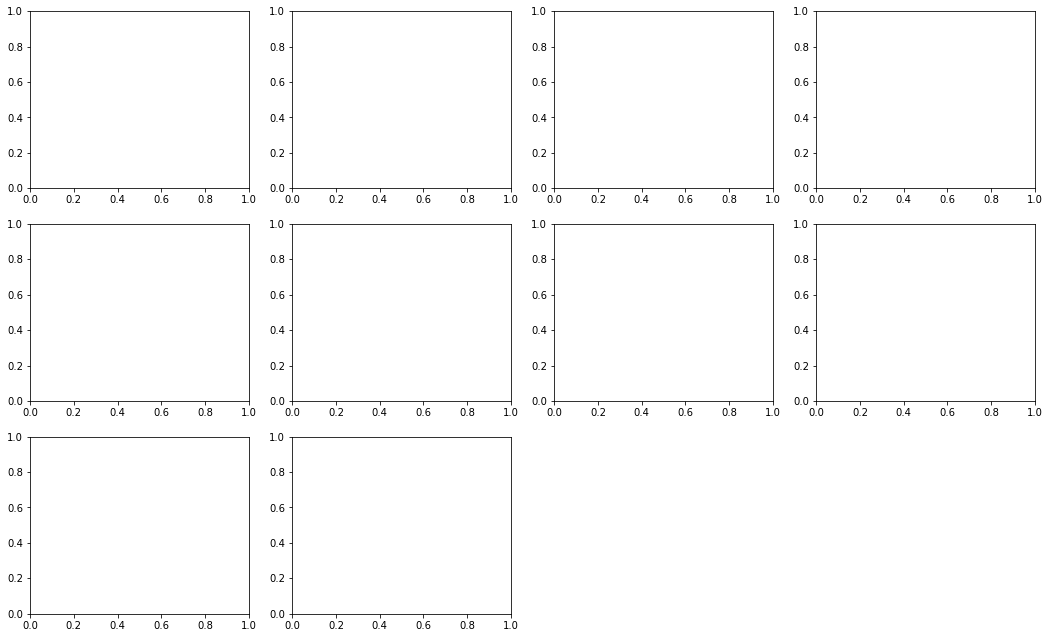

In [15]:
TrackSet_1, TrackSet_2 = DatasetLoader('disco')

train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((TrackSet_1))
    .map(map_data, num_parallel_calls=AUTOTUNE)
    .shuffle(3)
    .batch(BATCH_SIZE)
)
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices((TrackSet_2))
    .map(map_data, num_parallel_calls=AUTOTUNE)
    .shuffle(3)
    .batch(BATCH_SIZE)
)

#optimizer = tf.keras.optimizers.Adam(0.0003,beta_1=0.9, beta_2=0.999,epsilon=1e-08)

random_vector_for_generation = tf.random.normal(shape=[num_examples_to_generate, latent_dim])
model_disco = CVAE(latent_dim)

# Pick a sample of the test set for generating output images
assert BATCH_SIZE >= num_examples_to_generate
for test_batch in test_dataset.take(1):
    test_sample = test_batch[0]

generate_and_save_images(model_disco, 0, test_sample, 'disco')
train(train_dataset, test_dataset, model_disco, 'disco')

anim_file_1 = 'disco_cvae.gif'

with imageio.get_writer(anim_file_1, mode='I') as writer:
    filenames = glob.glob('disco*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file_1)


saved_disco = inference(test_dataset, model_disco)

In [16]:
music1=saved_disco[0][0]
ipd.Audio(music1,rate=3000)

In [17]:
music2=saved_disco[9][0]
ipd.Audio(music2,rate=3000)

In [18]:
music3=saved_disco[5][0]
ipd.Audio(music3,rate=3000)

## Metal

Epoch: 20, Test set ELBO: -6986.24267578125, time elapse for current epoch: 1.99015212059021


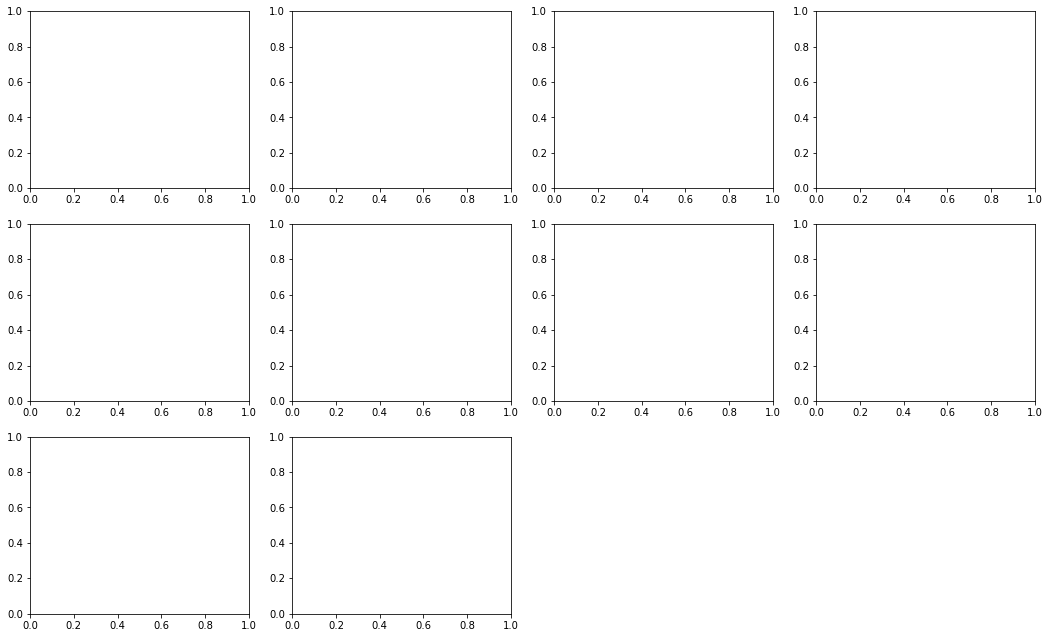

In [19]:
TrackSet_1, TrackSet_2 = DatasetLoader('metal')

train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((TrackSet_1))
    .map(map_data, num_parallel_calls=AUTOTUNE)
    .shuffle(3)
    .batch(BATCH_SIZE)
)
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices((TrackSet_2))
    .map(map_data, num_parallel_calls=AUTOTUNE)
    .shuffle(3)
    .batch(BATCH_SIZE)
)

#optimizer = tf.keras.optimizers.Adam(0.0003,beta_1=0.9, beta_2=0.999,epsilon=1e-08)

random_vector_for_generation = tf.random.normal(shape=[num_examples_to_generate, latent_dim])
model_metal = CVAE(latent_dim)

# Pick a sample of the test set for generating output images
assert BATCH_SIZE >= num_examples_to_generate
for test_batch in test_dataset.take(1):
    test_sample = test_batch[0]

generate_and_save_images(model_metal, 0, test_sample, 'metal')
train(train_dataset, test_dataset, model_metal, 'metal')

anim_file_1 = 'metal_cvae.gif'

with imageio.get_writer(anim_file_1, mode='I') as writer:
    filenames = glob.glob('metal*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file_1)


saved_metal = inference(test_dataset, model_metal)

In [20]:
music1=saved_metal[0][0]
ipd.Audio(music1,rate=3000)

In [21]:
music2=saved_metal[9][0]
ipd.Audio(music2,rate=3000)

In [22]:
music3=saved_metal[5][0]
ipd.Audio(music3,rate=3000)

## Dígitos

In [ ]:
#train_size = 60000
BATCH_SIZE = 10
#test_size = 10000
epochs = 10
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 10

#DIGITS_PATH = 'Data/data/01'

#optimizer = tf.keras.optimizers.Adam(0.0003,beta_1=0.9, beta_2=0.999,epsilon=1e-08)

In [ ]:
from os import listdir
from os.path import isfile, join
#mypath1 = 'Data/data/01/'
#mypath2 = 'Data/data/02/'
mypath1 = 'Data/data/teste1/'
mypath2 = 'Data/data/teste2/'
onlyfiles1 = [mypath1+f for f in listdir(mypath1) if isfile(join(mypath1, f))]
#onlyfiles1
onlyfiles2 = [mypath2+f for f in listdir(mypath2) if isfile(join(mypath2, f))]
#onlyfiles2

In [ ]:
TrackSet_1, TrackSet_2 = onlyfiles1, onlyfiles2

In [ ]:
def load_dif(file_):
    data_, sampling_rate = librosa.load(file_)
    duration = librosa.get_duration(y=data_, sr=sampling_rate)
    data_, sampling_rate = librosa.load(file_, sr=3000/duration)
    data_ = data_.reshape(1,3000)
    return data_


In [ ]:
map_data = lambda filename: tf.compat.v1.py_func(load_dif, [filename], [tf.float32])

train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((TrackSet_1))
    .map(map_data, num_parallel_calls=AUTOTUNE)
    .shuffle(3)
    .batch(BATCH_SIZE)
)
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices((TrackSet_2))
    .map(map_data, num_parallel_calls=AUTOTUNE)
    .shuffle(3)
    .batch(BATCH_SIZE)
)

#optimizer = tf.keras.optimizers.Adam(0.0003,beta_1=0.9, beta_2=0.999,epsilon=1e-08)

random_vector_for_generation = tf.random.normal(shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim, shape=3000)

# Pick a sample of the test set for generating output images
assert BATCH_SIZE >= num_examples_to_generate
for test_batch in test_dataset.take(1):
    test_sample = test_batch[0]

generate_and_save_images(model, 0, test_sample, 'digits')
train(train_dataset, test_dataset, model, 'digits')

anim_file_1 = 'digits_cvae.gif'

with imageio.get_writer(anim_file_1, mode='I') as writer:
    filenames = glob.glob('digits*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file_1)


saved_musics = inference(test_dataset, model)

music1=saved_musics[0][0]
ipd.Audio(music1,rate=3000)

music2=saved_musics[9][0]
ipd.Audio(music2,rate=3000)

music3=saved_musics[5][0]
ipd.Audio(music3,rate=3000)

In [ ]:
saved_musics = inference(test_dataset, model)

music1=saved_musics[0][0]
ipd.Audio(music1,rate=3000)

In [ ]:
music2=saved_musics[9][0]
ipd.Audio(music2,rate=3000)

In [ ]:
music3=saved_musics[100][0]
ipd.Audio(music3,rate=3000)

In [ ]:
music3=saved_musics[100][0]